<a href="https://colab.research.google.com/github/doctorsmylie/mtg-draft-agent/blob/main/testing/DraftBot_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Configure Drive or Jupyter notebook -- only runs when first loaded
if "CONFIG_DONE" not in globals():
    # Need to mount drive and clone repo to access data and functions
    try:
        from google.colab import drive  # type: ignore

        IN_COLAB = True

        # clone repo
        !git clone https://github.com/doctorsmylie/mtg-draft-agent
        %cd mtg-draft-agent

    except ModuleNotFoundError:
        IN_COLAB = False

    # Finish configuration -- also configures notebook outside of Colab
    %run "project_path.ipynb"
else:
    print("Config done")

Cloning into 'mtg-draft-agent'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 220 (delta 1), reused 1 (delta 1), pack-reused 218 (from 1)
Receiving objects: 100% (220/220), 9.28 MiB | 3.87 MiB/s, done.
Resolving deltas: 100% (121/121), done.
/content/mtg-draft-agent
Starting config...
Running in Colab? Yes

Configuring Google Colab...
Mounting Drive...
Mounted at /content/mtg-draft-agent/drive
BASE_PATH =  /content/mtg-draft-agent
DATA_FOLDER = /content/mtg-draft-agent/drive/MyDrive/Erdos25/MTGdraft
BASE_PATH == os.getcwd(): True

Configuration done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

# from datasets import Dataset
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import pathlib
from itertools import product
from sklearn.model_selection import train_test_split

from time import time
from tqdm.auto import tqdm

import functions.card_io as card_io
import functions.utils as utils

# Setting device on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Expansion code
expansion = "DSK"

# Load draft history into a dataframe
draftfilename = "draft_data_public." + expansion + ".PremierDraft.csv.gz"
draft_file = pathlib.Path(DATA_FOLDER, expansion, draftfilename)

draftdata = pd.read_csv(draft_file, compression="gzip", nrows=10000)

In [4]:
# Get unique draft ids
draft_ids = draftdata["draft_id"].unique()

# Get card names and card-index dictionaries
card_names, card_to_idx, idx_to_card = card_io.get_cards_from_draft_df(draftdata)
vocab_size = len(card_names)

# Get draft history
drafts = card_io.get_played_drafts(draftdata, card_to_idx)
max_pack_size = drafts["pick_number"].max() + 1

# Use expansion size as padding_idx
PAD_IDX = vocab_size

1/239: 0.171
2/239: 0.163
3/239: 0.162
4/239: 0.182
5/239: 0.167
6/239: 0.16
7/239: 0.167
8/239: 0.162
9/239: 0.174
10/239: 0.179
11/239: 0.17
12/239: 0.165
13/239: 0.185
14/239: 0.262
15/239: 0.275
16/239: 0.265
17/239: 0.256
18/239: 0.247
19/239: 0.274
20/239: 0.275
21/239: 0.253
22/239: 0.252
23/239: 0.266
24/239: 0.291
25/239: 0.27
26/239: 0.283
27/239: 0.165
28/239: 0.184
29/239: 0.161
30/239: 0.166
31/239: 0.165
32/239: 0.165
33/239: 0.165
34/239: 0.184
35/239: 0.16
36/239: 0.167
37/239: 0.164
38/239: 0.166
39/239: 0.165
40/239: 0.169
41/239: 0.173
42/239: 0.16
43/239: 0.157
44/239: 0.165
45/239: 0.159
46/239: 0.166
47/239: 0.175
48/239: 0.164
49/239: 0.159
50/239: 0.162
51/239: 0.161
52/239: 0.17
53/239: 0.188
54/239: 0.165
55/239: 0.158
56/239: 0.164
57/239: 0.161
58/239: 0.168
59/239: 0.166
60/239: 0.172
61/239: 0.169
62/239: 0.167
63/239: 0.157
64/239: 0.164
65/239: 0.156
66/239: 0.179
67/239: 0.158
68/239: 0.165
69/239: 0.171
70/239: 0.167
71/239: 0.16
72/239: 0.186
73/239: 

In [5]:
drafts.head(5)

,draft_id,pack_number,pick_number,pick,pack,pool
0,53401b113a4f425fa26e60edd314dd27,0,0,123,"[39, 58, 78, 90, 122, 123, 154, 160, 180, 190,...",[]
1,53401b113a4f425fa26e60edd314dd27,0,1,89,"[89, 90, 115, 146, 149, 165, 202, 208, 210, 21...",[123]
2,53401b113a4f425fa26e60edd314dd27,0,2,73,"[8, 11, 17, 73, 93, 112, 158, 172, 190, 230, 2...","[89, 123]"
3,53401b113a4f425fa26e60edd314dd27,0,3,73,"[8, 33, 38, 64, 73, 86, 91, 112, 234, 253, 273]","[73, 89, 123]"
4,53401b113a4f425fa26e60edd314dd27,0,4,254,"[14, 33, 42, 115, 119, 129, 147, 217, 253, 254]","[73, 73, 89, 123]"


# LSTM
Use an LSTM to build a bot.

Unlike a Transformer, this architecture can be trained sequentially out of the box. We could force a Transformer to train sequentially, but then we'd lose the parallelism advantage and use more parameters than an LSTM. At least now we have a smaller model.

In [6]:
def tensorize_lists(*args, padding_value=PAD_IDX, device=None):
    """
    Turns the list of arguments into a padded tensor.
    - Each argument is a list of tokens, and they will be padded to have the same
      length.
    - Returns the padded tensor and the original length of each argument
    """
    # Change arguments to tensors if they aren't already
    pack_tensors = []
    for pack in args:
        # Turn list into a tensor
        if not isinstance(pack, torch.Tensor):
            # If device doesn't matter
            if device is None:
                pack_tensors.append(torch.tensor(pack))
            # Create on specified device
            else:
                pack_tensors.append(torch.tensor(pack, device=device))
        # Store the tensors
        else:
            # Device doesn't matter
            if device is None:
                pack_tensors.append(pack)
            # Move to specified device
            else:
                pack_tensors.append(pack.to(device))

    # Store lengths
    lengths = [pack.shape[0] for pack in pack_tensors]
    pack_size = max(lengths)

    # Pad to shape (batch_size, pack_size)
    pack_batch = pad_sequence(
        pack_tensors, batch_first=True, padding_value=padding_value
    )

    return pack_batch, lengths

In [7]:
class DraftBotLSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        hidden_dim,
        num_layers=1,
        padding_idx=None,
        p_LSTM=0.0,
        p_out=0.0,
    ):
        super().__init__()

        # Attributes
        self.vocab_size = vocab_size

        # For padding sequences. We later add a "word" to the embedding layer to
        # encode this new padding index
        if padding_idx is None:
            self.padding_idx = vocab_size
        else:
            self.padding_idx = padding_idx

        # LSTM followed by a full layer that produces logits
        self.embedding = nn.Embedding(
            vocab_size + 1, embed_dim, padding_idx=self.padding_idx
        )
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=p_LSTM,
        )
        self.dropout = nn.Dropout(p=p_out)
        self.output_layer = nn.Linear(
            hidden_dim, vocab_size
        )  # maps hidden state to logits

    # Returns the device the model sits on
    def device(self):
        return next(self.parameters()).device

    def forward(self, pack_batch, hidden_state=None):
        """
        pack_batch: [Tensor] of shape (batch_size, pack_size). Contains a batch of packs.
        hidden_state: Tuple of (h_0, c_0), each of shape (batch_size, 1, hidden_dim)
        Returns:
            logits: shape (batch_size, seq_len, pack_size) with seq_len=1
            hidden_state: final hidden state (for next step)
        """
        pack_embed = self.embedding(pack_batch)  # (batch_size, pack_size, embed_dim)
        # print(' ------------ ')
        # print('Embedding:', pack_embed.shape)

        # Careful with padded tokens
        mask = (pack_batch != self.padding_idx).unsqueeze(
            -1
        )  # (batch_size, seq_len, 1)
        valid_counts = mask.sum(dim=1, keepdim=True)  # (batch_size, 1, 1)

        # pool cards into a single vector (i.e. change pack_size to 1)
        pack_pooled = pack_embed.sum(
            dim=1, keepdim=True
        )  # shape (batch_size, 1, embed_dim)
        pack_pooled = pack_pooled / valid_counts

        # print('Embedding pooled:', pack_pooled.shape)
        # Q: Do I need to average the embeddings? Isn't this lossy?

        # Pass through LSTM
        lstm_out, hidden = self.lstm(
            pack_pooled, hidden_state
        )  # shape: (batch_size, 1, hidden_dim)

        # print()
        # print('LSTM output')
        # print('lstm_out:', lstm_out.shape)
        # print('hidden state:', len(hidden))
        # for i,h_i in enumerate(hidden):
        #       print(f'hidden_{i}: {h_i.shape}')
        # print()

        # Dropout layer
        lstm_out_drop = self.dropout(lstm_out)

        # Map LSTM output to logits
        logits = self.output_layer(lstm_out_drop)  # shape: (batch_size, 1, vocab_size)
        # print('Logits:', logits.shape)
        # print()

        # Mask logits of tokens not in pack_batch
        mask = utils.create_logit_mask(
            pack_batch, self.vocab_size, padding_idx=self.padding_idx
        )

        # Add a dimension to match logits.shape
        mask = mask.unsqueeze(1)

        # print('mask:', mask.shape)

        # Be careful not to change tensors involved in gradient computations in place.
        # (it breaks gradient and backpropagation, possibly silently).
        # "Changing in place" means overwritting the underlying data storage.
        # masked_fill creates a new tensor, and the assignment logits = ... just changes
        # references, i.e. `logits` now points to the output of masked_fill instead of
        # the old value of logits
        logits = logits.masked_fill(~mask, -torch.inf)

        # print('New logits:', logits.shape)

        return logits, hidden

    def predict(self, pack_batch, hidden_state=None):
        """
        pack_batch: [Tensor] of shape (batch_size, pack_size). Contains a batch of packs.
        hidden_state: Tuple of (h_0, c_0), each of shape (batch_size, 1, hidden_dim)
        Returns:
            predictions: shape (batch_size,) The chosen card token from each batch
            hidden_state: final hidden state
        """
        # pack.shape = (batch_size, pack_size)
        logits, hidden = self(
            pack_batch, hidden_state
        )  # shape: (batch_size, 1, vocab_size)

        # Get predictions from the last time step
        last_logits = logits[:, -1, :]  # (batch_size, vocab_size)
        predictions = torch.argmax(last_logits, dim=-1)  # (batch,)

        return predictions, hidden

    def predict_single(self, pack, hidden_state=None):
        """
        pack: List of card tokens. We turn the pack into a tensor of shape (batch_size, pack_size)
              with batch_size=1.
        hidden_state: Tuple of (h_0, c_0), each of shape (batch_size, 1, hidden_dim)
        Returns:
            prediction: The chosen card token from the pack.
            hidden_state: final hidden state
        """
        pack_batch, _ = tensorize_lists(
            pack, device=self.device(), padding_value=self.padding_idx
        )

        return self.predict(pack_batch, hidden_state)

    def predict_batch(self, pack_list, hidden_state=None):
        """
        pack_list: List of card packs. Each pack is a list of card tokens.
                  We turn the pack list into a tensor of shape (batch_size, pack_size)
                  with batch_size=len(pack_list), and we pad all packs to the maximum
                  pack size.
        hidden_state: Tuple of (h_0, c_0), each of shape (batch_size, 1, hidden_dim)
        Returns:
            predictions: The chosen card token from each pack.
            hidden_state: final hidden state
        """
        pack_batch, _ = tensorize_lists(
            *pack_list, device=self.device(), padding_value=self.padding_idx
        )
        # pack_padded = pack_padded_sequence(pack_batch, lengths, batch_first=True, enforce_sorted=False)

        # Obtain predictions
        predictions, hidden = self.predict(pack_batch, hidden_state)
        # Note: No need to pad_packed_sequence because I return a single token

        return predictions, hidden

## Initial testing

In [ ]:
# vocab_size, embed_dim, hidden_dim
vocab_size = 100
embed_dim = 250
hidden_dim = 150
DraftBot0 = DraftBotLSTM(vocab_size, embed_dim, hidden_dim)

card_packs = [[1, 3, 5, 7, 9], [11, 13, 15, 17], [21, 23, 25, 27, 29, 31]]
# card_packs = [torch.tensor(pack) for pack in card_packs]

for pack in card_packs:
    print(len(pack))

In [ ]:
# Predictions by hand
logit_list = []
choices = []
hidden_state = None
for pack in card_packs:
    input = torch.tensor(pack).unsqueeze(0)
    # input = torch.tensor([pack]*2)

    # print('Input:', input.shape)
    # print('Raw:', pack)
    # print('Tensor:', input)
    # print()

    logits, hidden_state = DraftBot0.forward(input, hidden_state)
    logit_list.append(logits)
    choices.append(torch.argmax(logits, dim=-1).squeeze())

    print("logits:", logits.shape)
    print("choice:", choices[-1].shape)
    print()

print("Choices:", choices)

In [ ]:
# Using .predict_single
choices = []
hidden_state = None
for pack in card_packs:
    prediction, hidden = DraftBot0.predict_single(pack)
    choices.append(prediction)

print("Choices:", choices)

In [ ]:
# Using .predict_batch
# Using .predict_single
choices, hidden = DraftBot0.predict_batch(card_packs)
print("Choices:", choices)

# Mock dataset

In [ ]:
vocab_size = 50
seq_len = 5
batch_size = 32
n_samples = 1000

torch.manual_seed(0)
X = torch.randint(0, vocab_size, (n_samples, seq_len))  # (n_samples, seq_len)
y = torch.randint(0, vocab_size, (n_samples, 1))  # targets per position

dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Model, Loss and Optimizer
embed_dim = 64
hidden_dim = 128
model = DraftBotLSTM(vocab_size, embed_dim, hidden_dim)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
epochs = 5
for epoch in range(epochs):
    total_loss = 0

    for xb, yb in dataloader:
        logits, _ = model(xb)  # (batch, seq_len, vocab)
        # Flatten for CrossEntropyLoss
        loss = loss_fn(logits.view(-1, vocab_size), yb.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")

In [ ]:
# Show some predictions to see how well the model trained
for idx, (xb, yb) in enumerate(dataloader):
    prediction, hidden = model.predict(xb)

    results = torch.stack([yb.T, prediction.unsqueeze(0)])

    print("True/Pred")
    print(results)
    print()

    if idx > 5:
        break

### Technical checks

In [ ]:
print(xb.shape)
yb_pred, _ = model(xb)

print(yb_pred.shape)

In [ ]:
count = 0
for xb, yb in dataloader:
    print(count)
    print(xb.shape)
    print(yb.shape)
    print()

    count += 1

# Try to imitate human drafting

## Custom Dataset and DataLoaders

In [8]:
# Dataset to return a single player's game
class PlayerDataset(Dataset):
    """
    A Dataset class that handles the players in our dataset. When called, it
    returns all the turns of a chosen player.
    """

    def __init__(self, df):
        self.df = df
        self.players = df["draft_id"].unique()
        self.padding_idx = PAD_IDX

    def __len__(self):
        """
        Number of players in our dataset
        """
        return len(self.players)

    def __getitem__(self, idx):
        """
        Returns the lists of packs and picks of the player with index idx.
        Packs and picks are sorted by turn order.
        """
        id = self.players[idx]
        df_player = self.df[self.df["draft_id"] == id]

        # Make sure that turns are sorted correctly
        df_player = df_player.sort_values(
            by=["pack_number", "pick_number"], ascending=True
        )

        # Extract packs and picks in turn sequence
        packs = []
        picks = []
        for idx, row in df_player.iterrows():
            # LSTMs (and tokens in general) work best with long dtype
            pack = torch.tensor(row["pack"], dtype=torch.long)
            pick = torch.tensor(row["pick"], dtype=torch.long)

            packs.append(pack)
            picks.append(pick)

        # Return the lists of packs and picks of a single player
        return packs, picks

    def __repr__(self):
        return (
            f"PlayerDataset with {len(self)} players\n{self.df.to_string(max_rows=5)}"
        )

    # Convenience method for counting the number of turns
    # Remember that __get_item__ returns two lists whose lengths equal
    # the number of turns
    def num_turns(self):
        return len(self.__getitem__(0)[0])


# Custom collate function.
# It's used for training the LSTM batching by player
def collate_player_turns(batch):
    """
    Collate function for PlayerDataset. Creates batches of players, and returns
    a list of batches. Each batch contains the game state (packs and picks) in a
    single turn, and for all the player in the batch. The list is sorted
    chronologically by turn.
    We assume all players have the same number of turns, and the same number of
    options in each turn.

    args:
    batch: list of tuples (packs, picks). Each tuple contains the draft data
    of a single player in turn order.

    Returns:
    pack_batches: list of packs for each turn. Each element is a tensor of shape
                  (batch_size, pack_size), where batch_size is the number of players.
    pick_batches: list of picks for each turn. Each element is a tensor of shape
                  (batch_size,), where batch_size is the number of players.
    """
    # batch: list of tuples (packs, picks). length = number of players

    # batch[0] = (packs, picks) of first player
    # num. turns = len(packs), equiv. len(picks)
    n_turns = len(batch[0][0])

    # pack and pick batches, sorted by turn
    # Element idx will be the play info of all players in turn idx
    pack_batches = []
    pick_batches = []
    for turn in range(n_turns):
        # Extract turn info from all players
        packs_turn = []
        picks_turn = []
        for player_pack, player_pick in batch:
            packs_turn.append(player_pack[turn])
            picks_turn.append(player_pick[turn])

        # Stack and store
        # We're assuming all players have the same number of options in each turn,
        # so we can stack their packs without padding.
        pack_batches.append(torch.stack(packs_turn))
        pick_batches.append(torch.stack(picks_turn))

    return pack_batches, pick_batches

## Training and evaluation functions

In [190]:
# Training and evaluation functions
def train_epoch(
    model, dataloader, optimizer, loss_fn, chunk_size=max_pack_size, device=None
):
    """
    chunk_size: Back propagate over a smaller number of turns.
                The default is the size of a pack (i.e. the length of one "round" of
                drafting).
                If None, we backpropagate over all turns.
    """
    # Move model to new device
    if device is not None:
        model = model.to(device)

    # Initialize training mode
    model.train()

    # Remember: In PlayerDataset, each entry has the game information of a player,
    # which consists of two lists of length equal to the number of turns
    num_batches = len(dataloader)
    num_players = len(dataloader.dataset)
    num_turns = dataloader.dataset.num_turns()

    # Accumulate the correct picks made by all players of each batch and on each turn
    all_correct = torch.zeros(num_batches, num_turns)

    # Accumulate loss over all players and all turns
    total_loss = 0

    # Each (pack_batches, pick_batches) is a list of turn states for a player batch
    batch_count = 0
    for pack_batches, pick_batches in tqdm(dataloader):
        # Each batch is a group of players, but the last batch may be smaller
        batch_size = len(pack_batches[0])

        # Initialize variables at the start of the game
        batch_loss = 0
        hidden_state = None
        optimizer.zero_grad()

        # In case we want to backpropagate the whole game
        if chunk_size is None:
            chunk_size = num_turns

        # Play game and backpropagate every chunk_size turns
        for t0 in range(0, num_turns, chunk_size):
            # End the chunk at the game's end, not later
            chunk_end = min(t0 + chunk_size, num_turns)

            # Play chunk_size turns
            for t in range(t0, chunk_end):
                pack_batch = pack_batches[t]
                pick_batch = pick_batches[t]

                if device is not None:
                    pack_batch = pack_batch.to(device)
                    pick_batch = pick_batch.to(device)

                # Cards available to pick
                pack_size = torch.tensor(pack_batch.shape[1], device=device)

                # Forward pass -- remember hidden state from previous turn
                logits, hidden_state = model(pack_batch, hidden_state=hidden_state)

                # Note: logits is shaped (batch_size, seq_len, vocab_size) with seq_len=1
                # but loss functions such as cross entropy expect shape
                # (batch_size, vocab_size). That's why I slice here
                logits = logits[:, -1, :]

                # Accumulate losses of all players, normalized by pack size
                # if pack_size > 1:
                #     batch_loss += loss_fn(logits, pick_batch) / torch.log(pack_size)
                # else:
                #     batch_loss += loss_fn(logits, pick_batch)
                batch_loss += loss_fn(logits, pick_batch)

                # Count the number of players that picked the correct card
                predictions = torch.argmax(logits, dim=-1)  # (batch,)
                all_correct[batch_count, t] = (predictions == pick_batch).sum()

            # I accumulated losses for several players across several turns.
            # To keep magnitudes and variables interpretable (e.g. gradients),
            # I backpropagate the average loss
            played_turns = chunk_end - t0
            mean_batch_loss = batch_loss / (batch_size)

            # Backpropagate
            mean_batch_loss.backward()
            optimizer.step()

            # Reset optimizer
            optimizer.zero_grad()

            # Detach hidden state to truncate gradients every chunk_size turns
            hidden_state = tuple(h.detach() for h in hidden_state)

            # ... or just reset the hidden state
            # hidden_state = None

            # Accumulate losses of all players
            total_loss += batch_loss.item()

        # Advance batch counter
        batch_count += 1

    # Add correct choices over all batches (i.e. over all players)
    # then average over the number of players
    # accuracy_per_turn = all_correct
    accuracy_per_turn = all_correct.sum(dim=0) / num_players  # (num_turns,)

    # Average total loss over the number of players and the number of turns
    mean_loss = total_loss / (num_players)

    return mean_loss, accuracy_per_turn


@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device=None):
    # Move model to new device
    if device is not None:
        model = model.to(device)

    # Initialize evaluation mode
    model.eval()

    # Remember: In PlayerDataset, each entry has the game information of a player,
    # which consists of two lists of length equal to the number of turns
    num_batches = len(dataloader)
    num_players = len(dataloader.dataset)
    num_turns = dataloader.dataset.num_turns()

    # Accumulate the correct picks made by all players of each batch and on each turn
    all_correct = torch.zeros(num_batches, num_turns)

    # Accumulate loss over all players and all turns
    total_loss = 0

    # Each (pack_batches, pick_batches) is a list of turn states for a player batch
    batch_count = 0
    for pack_batches, pick_batches in dataloader:
        # Each batch is a group of players, but the last batch may be smaller
        batch_size = len(pack_batches[0])

        # Initialize variables at the start of the game
        batch_loss = 0
        hidden_state = None

        for t in range(num_turns):
            # Extract turn info and move it to new device (if required)
            pack_batch = pack_batches[t]
            pick_batch = pick_batches[t]

            if device is not None:
                pack_batch = pack_batch.to(device)
                pick_batch = pick_batch.to(device)

            # Cards available to pick
            pack_size = torch.tensor(pack_batch.shape[1], device=device)

            # Forward pass
            logits, hidden_state = model(pack_batch, hidden_state=hidden_state)

            # Note: logits is shaped (batch_size, seq_len, vocab_size) with seq_len=1
            # but loss functions such as cross entropy expect shape
            # (batch_size, vocab_size). That's why I slice here
            logits = logits[:, -1, :]

            # Accumulate losses of all players, normalized by pack size
            if pack_size > 1:
                batch_loss += loss_fn(logits, pick_batch) / torch.log(pack_size)
            else:
                batch_loss += loss_fn(logits, pick_batch)
            # batch_loss += loss_fn(logits, pick_batch)

            # Count the number of players that picked the correct card
            predictions = torch.argmax(logits, dim=-1)  # (batch,)
            all_correct[batch_count, t] = (predictions == pick_batch).sum()

        # Accumulate batch losses. In total, this accumulates losses of all players
        total_loss += batch_loss.item()

        # Advance batch counter
        batch_count += 1

    # Add correct choices over all batches (i.e. over all players)
    # then average over the number of players
    # accuracy_per_turn = all_correct
    accuracy_per_turn = all_correct.sum(dim=0) / num_players  # (num_turns,)

    # Average total loss over the number of players and the number of turns
    mean_loss = total_loss / (num_players)

    return mean_loss, accuracy_per_turn

In [191]:
# Calculate probability of random choice
tt = np.arange(14, dtype=float)
prob_random = 1 / np.flip(tt + 1)

# Rearange
tt = np.arange(42)
prob_random = np.tile(prob_random, 3)

# Split plot by turns
def plot_by_chunks(series, dt, label, *args, **kwargs):
  Ts = np.arange(0, series.shape[0], dt)

  for t0 in Ts:
    t_end = min(t0 + dt, series.shape[0])
    I = np.arange(t0, t_end).astype(int)

    # Label only the first chunk to not saturate legend
    if t0==0:
      plt.plot(I, series[I], label=label, *args, **kwargs)
    else:
      plt.plot(I, series[I], *args, **kwargs)

## Train the model

In [192]:
# Split players into train/val/test
draft_ids = drafts["draft_id"].unique()

train_ids, temp_ids = train_test_split(draft_ids, test_size=0.2, random_state=304)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=304)

# Split Dataframe
drafts_train = drafts[drafts["draft_id"].isin(train_ids)]
drafts_val = drafts[drafts["draft_id"].isin(val_ids)]
drafts_test = drafts[drafts["draft_id"].isin(test_ids)]

# Create custom Datasets for each split
dataset_train = PlayerDataset(drafts_train)
dataset_val = PlayerDataset(drafts_val)
dataset_test = PlayerDataset(drafts_test)

In [193]:
# Model, Loss and Optimizer
embed_dim = 128
hidden_dim = 512
num_layers = 5
p_LSTM = 0.3
p_out = 0.5
model = DraftBotLSTM(
    vocab_size, embed_dim, hidden_dim, num_layers=num_layers, p_LSTM=p_LSTM, p_out=p_out
)

batch_size = 64
loss_fn = nn.CrossEntropyLoss()

lr = 1e-3
weight_decay = 1e-2
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

In [194]:
# Create custom DataLoaders
dlss = []
for dataset in [dataset_train, dataset_val, dataset_test]:
    dls = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_player_turns
    )
    dlss.append(dls)

dls_train, dls_val, dls_test = dlss

In [195]:
# Training loop parameters
num_epochs = 50
num_turns = dataset_train.num_turns()

# Back propagate over the whole game
# If chunk_size is None, we back propagate over a single round of the draft
# (i.e. over 14 turns)
# chunk_size = 42
chunk_size = None

train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)

train_accuracies = torch.zeros((num_epochs, num_turns))
val_accuracies = torch.zeros((num_epochs, num_turns))

for epoch in range(num_epochs):
    # Train
    train_loss, train_accuracy_epoch = train_epoch(
        model, dls_train, optimizer, loss_fn, chunk_size=chunk_size, device=device
    )

    # Evaluate on validation set
    val_loss, val_accuracy_epoch = evaluate(model, dls_val, loss_fn, device=device)

    # Print results
    print(
        f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}\n"
    )

    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss

    train_accuracies[epoch, :] = train_accuracy_epoch.cpu()
    val_accuracies[epoch, :] = val_accuracy_epoch.cpu()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/50: Train Loss = 1.1830, Val Loss = 1.5066



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/50: Train Loss = 1.0975, Val Loss = 1.4253



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/50: Train Loss = 1.0374, Val Loss = 1.4268



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/50: Train Loss = 1.0200, Val Loss = 1.4181



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/50: Train Loss = 1.0073, Val Loss = 1.4030



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/50: Train Loss = 0.9960, Val Loss = 1.3919



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/50: Train Loss = 0.9892, Val Loss = 1.3841



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/50: Train Loss = 0.9818, Val Loss = 1.3821



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/50: Train Loss = 0.9753, Val Loss = 1.3826



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50: Train Loss = 0.9738, Val Loss = 1.3819



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50: Train Loss = 0.9695, Val Loss = 1.3800



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50: Train Loss = 0.9695, Val Loss = 1.3777



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50: Train Loss = 0.9674, Val Loss = 1.3739



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50: Train Loss = 0.9661, Val Loss = 1.3730



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50: Train Loss = 0.9596, Val Loss = 1.3708



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50: Train Loss = 0.9595, Val Loss = 1.3682



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50: Train Loss = 0.9540, Val Loss = 1.3651



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50: Train Loss = 0.9512, Val Loss = 1.3670



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50: Train Loss = 0.9477, Val Loss = 1.3679



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50: Train Loss = 0.9498, Val Loss = 1.3659



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50: Train Loss = 0.9474, Val Loss = 1.3656



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50: Train Loss = 0.9447, Val Loss = 1.3637



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50: Train Loss = 0.9439, Val Loss = 1.3648



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50: Train Loss = 0.9438, Val Loss = 1.3670



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50: Train Loss = 0.9397, Val Loss = 1.3659



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50: Train Loss = 0.9389, Val Loss = 1.3685



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50: Train Loss = 0.9396, Val Loss = 1.3662



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50: Train Loss = 0.9353, Val Loss = 1.3652



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50: Train Loss = 0.9345, Val Loss = 1.3684



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50: Train Loss = 0.9353, Val Loss = 1.3648



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50: Train Loss = 0.9331, Val Loss = 1.3676



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50: Train Loss = 0.9325, Val Loss = 1.3700



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/50: Train Loss = 0.9295, Val Loss = 1.3715



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/50: Train Loss = 0.9294, Val Loss = 1.3689



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/50: Train Loss = 0.9287, Val Loss = 1.3726



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/50: Train Loss = 0.9269, Val Loss = 1.3705



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/50: Train Loss = 0.9277, Val Loss = 1.3677



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/50: Train Loss = 0.9252, Val Loss = 1.3719



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/50: Train Loss = 0.9244, Val Loss = 1.3683



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/50: Train Loss = 0.9239, Val Loss = 1.3740



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/50: Train Loss = 0.9232, Val Loss = 1.3720



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/50: Train Loss = 0.9219, Val Loss = 1.3723



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/50: Train Loss = 0.9198, Val Loss = 1.3759



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/50: Train Loss = 0.9201, Val Loss = 1.3738



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/50: Train Loss = 0.9180, Val Loss = 1.3772



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/50: Train Loss = 0.9180, Val Loss = 1.3718



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/50: Train Loss = 0.9151, Val Loss = 1.3777



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/50: Train Loss = 0.9170, Val Loss = 1.3735



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/50: Train Loss = 0.9163, Val Loss = 1.3776



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/50: Train Loss = 0.9151, Val Loss = 1.3753



(0.0, 1.54)

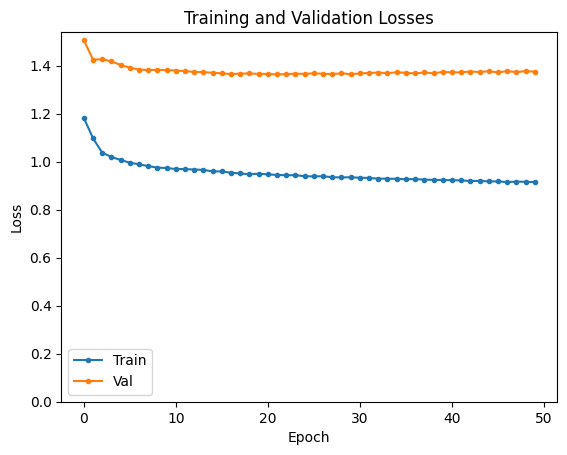

In [196]:
plt.plot(train_losses, label="Train", marker=".")
plt.plot(val_losses, label="Val", marker=".")
plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")

y_max = plt.ylim()[1]
y_max = utils.ceil_digit(y_max, digits=2)
plt.ylim(0, y_max)

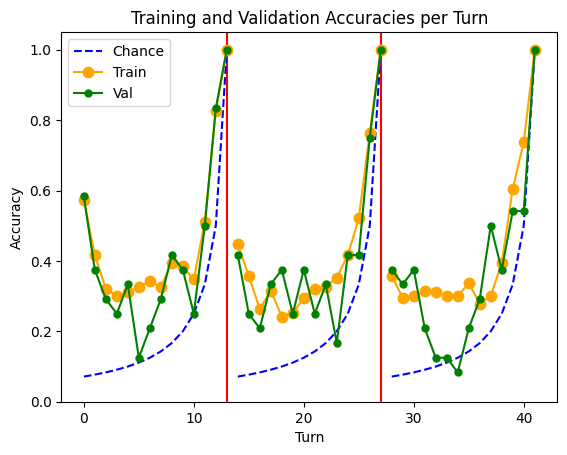

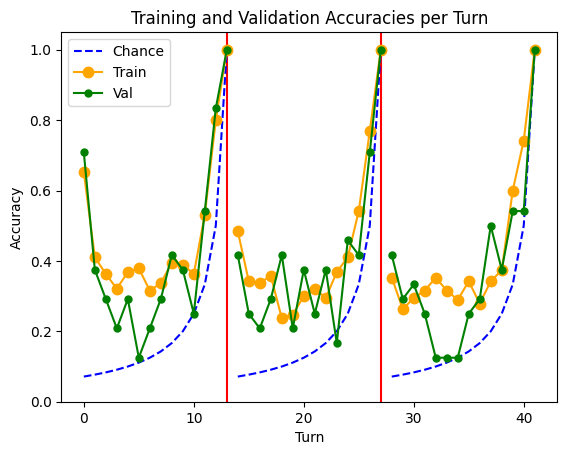

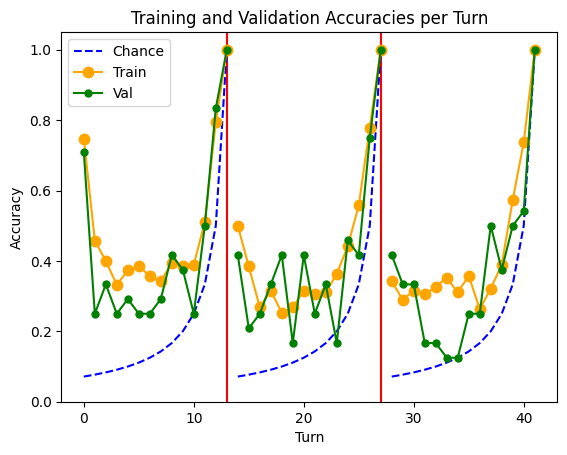

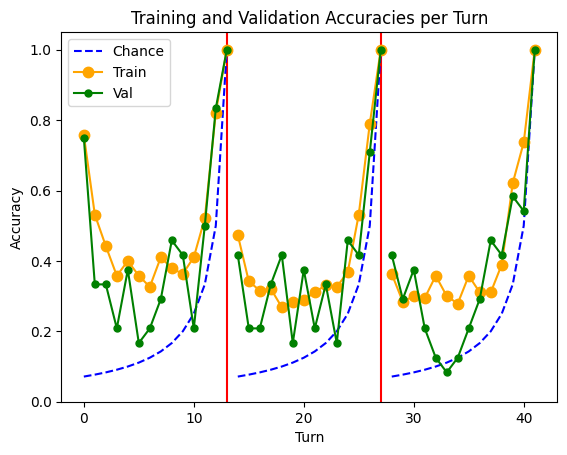

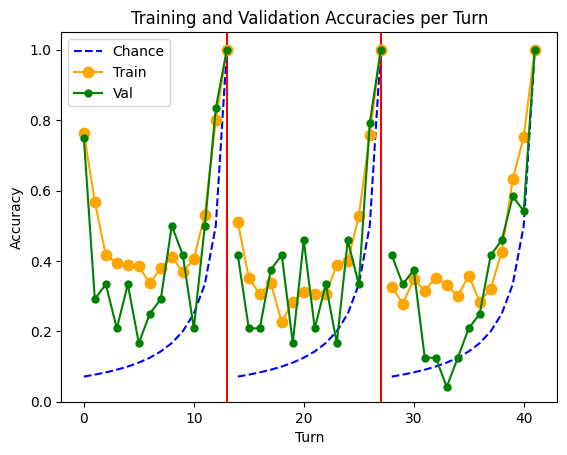

In [197]:
for epoch in range(9,num_epochs,10):
  # Separate packs
  plt.axvline(max_pack_size - 1, color="red")
  plt.axvline(2 * max_pack_size - 1, color="red")

  # Plot probability of random choice
  plot_by_chunks(prob_random, max_pack_size, 'Chance', '--', color='blue')

  # epoch = -1
  plot_by_chunks(train_accuracies[epoch, :], max_pack_size, 'Train', marker='.', markersize=15, color='orange')
  plot_by_chunks(val_accuracies[epoch, :], max_pack_size, 'Val', marker='.', markersize=10, color='green')
  plt.legend()

  plt.xlabel("Turn")
  plt.ylabel("Accuracy")
  plt.title("Training and Validation Accuracies per Turn")

  plt.ylim([0, 1.05])

  plt.show()